In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from IPython.display import clear_output
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# hyperparameters
low_res = 128
high_res = 256
lr = 1e-4
batch_size = 16
num_workers = 2
num_epochs = 5
train_path = "/kaggle/input/huge-dataset-of-images-super-resolution/SRGAN New Data/train"
val_path = "/kaggle/input/huge-dataset-of-images-super-resolution/SRGAN New Data/val"
backup_img_path = "/kaggle/input/huge-dataset-of-images-super-resolution/SRGAN New Data/train/000000.png"

In [3]:
#transforms for each image one high transform and other is low transform

low_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res, low_res)),
    transforms.ToTensor(),
])
high_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res, high_res)),
    transforms.ToTensor(),
])

In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class SR_Dataset(Dataset):
    def __init__(self, data_dir, backup_img_path):
        super(SR_Dataset, self).__init__()
        self.im_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Load and preprocess backup image only once
        backup_img = np.array(Image.open(backup_img_path))[:, :, :3]
        self.backup_low = low_transform(backup_img)
        self.backup_high = high_transform(backup_img)

    def __len__(self):
        return len(self.im_files)

    def __getitem__(self, index):
        try:
            loc = self.im_files[index]
            low_res_img = np.array(Image.open(loc))[:, :, :3]
            high_res_img = np.array(Image.open(loc))[:, :, :3]

            low_res_img = low_transform(low_res_img)
            high_res_img = high_transform(high_res_img)

            return low_res_img, high_res_img

        except Exception as e:
            return self.backup_low, self.backup_high

In [5]:
train_dataset = SR_Dataset(train_path,backup_img_path)
val_dataset = SR_Dataset(val_path,backup_img_path)

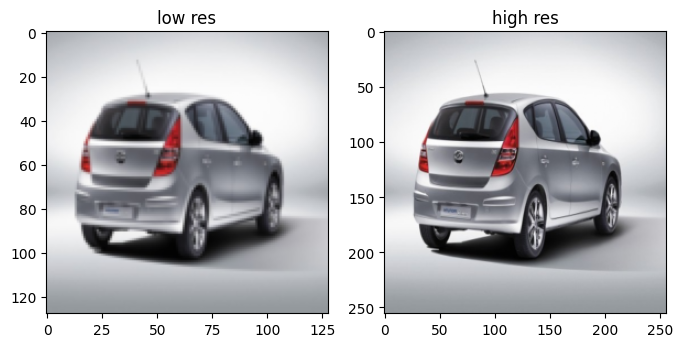

In [6]:
def show_image():
    sample_dataset = SR_Dataset(train_path,backup_img_path)
    sample_low_img,sample_high_img = sample_dataset[0]
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(sample_low_img.permute(1, 2, 0))
    axs[0].set_title("low res")
    axs[1].imshow(sample_high_img.permute(1, 2, 0))
    axs[1].set_title("high res")
    plt.show()
show_image()

In [7]:
vgg19_model = vgg19(weights=True).eval().to(device)
lf = list(vgg19_model.features)
lf[25]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 238MB/s]


Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [8]:
class vgg_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg19 = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self,first,second):
        vgg_first = self.vgg19(first)
        vgg_second = self.vgg19(second)
        perpectual_loss = self.loss(vgg_first,vgg_second)
        return perpectual_loss

In [9]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,use_act=True,use_bnorm = True, **kwargs):
        super().__init__()
        self.use_act = use_act
        self.cnn = nn.Conv2d(in_channels,out_channels,**kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_bnorm else nn.Identity()
        self.ac = (
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self,x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_act else x2

In [10]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_act=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

In [12]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_bnorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_act=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2)) 
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))

In [13]:
gen = Generator()
gen = gen.to(device)

In [14]:
low, high = train_dataset[0]
high = high.unsqueeze(0).to(device)
output = gen(low.unsqueeze(0).to(device))
vgg_l= vgg_Loss()
print("Generator Output shape: ",output.shape)
print("High res shape: ",high.shape)
print("VGG loss: ",vgg_l(output,high))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Generator Output shape:  torch.Size([1, 3, 256, 256])
High res shape:  torch.Size([1, 3, 256, 256])
VGG loss:  tensor(2.6226, device='cuda:0', grad_fn=<MseLossBackward0>)


In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride = idx % 2 + 1,
                    padding=1,
                    use_act=True,
                    use_bnorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

In [16]:
disc = Discriminator()
dic = disc.to(device)

In [17]:
output1 = disc(output)
print("Discriminator output shape: ",output1.shape)

Discriminator output shape:  torch.Size([1, 1])


In [18]:
def visualize_sr_sample(gen, dataset, device, epoch, index=0):
    gen.eval()
    with torch.no_grad():
        low, high = dataset[index]
        low = low.unsqueeze(0).to(device)
        output = gen(low).squeeze(0).cpu()
        low_img = TF.to_pil_image(low.squeeze(0).cpu())
        high_img = TF.to_pil_image(high)
        gen_img = TF.to_pil_image(output.clamp(0, 1))

        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Epoch {epoch}", fontsize=16)
        plt.subplot(1, 3, 1)
        plt.imshow(low_img)
        plt.title("Low Resolution")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gen_img)
        plt.title("Super Resolved")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(high_img)
        plt.title("High Resolution")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    gen.train()

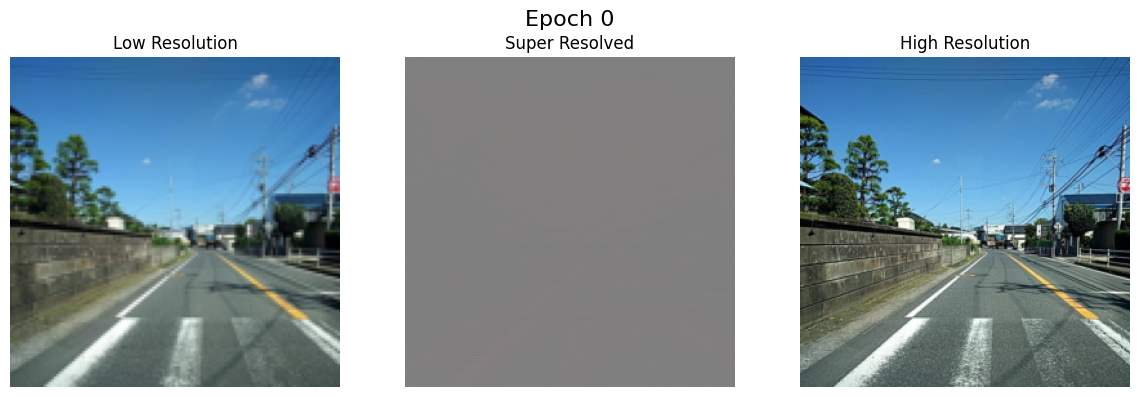

In [19]:
visualize_sr_sample(gen,val_dataset,device,0)

In [20]:
def train_progress(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.title("Training Progress")
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"Epoch [{epoch}/{num_epochs}], Discriminator Loss: {d_losses[-1]:.4f}, Generator Loss: {g_losses[-1]:.4f}")

In [21]:
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))

In [22]:
d_losses = []
g_losses = []
v_losses = []

In [23]:
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vgg_Loss()

In [24]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

  0%|          | 0/4217 [00:00<?, ?it/s]

Epoch [1/5]
  Generator Loss:     0.004705701023340225
  Discriminator Loss: 1.3321973085403442
  Validation Loss:    0.015687118750065565


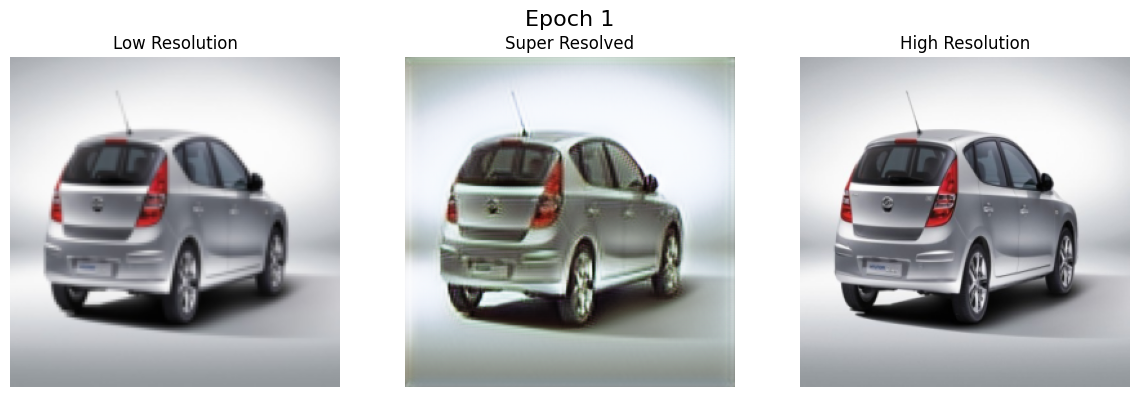

  0%|          | 0/4217 [00:00<?, ?it/s]

Epoch [2/5]
  Generator Loss:     0.006487769074738026
  Discriminator Loss: 0.6493551731109619
  Validation Loss:    0.01594099821522832


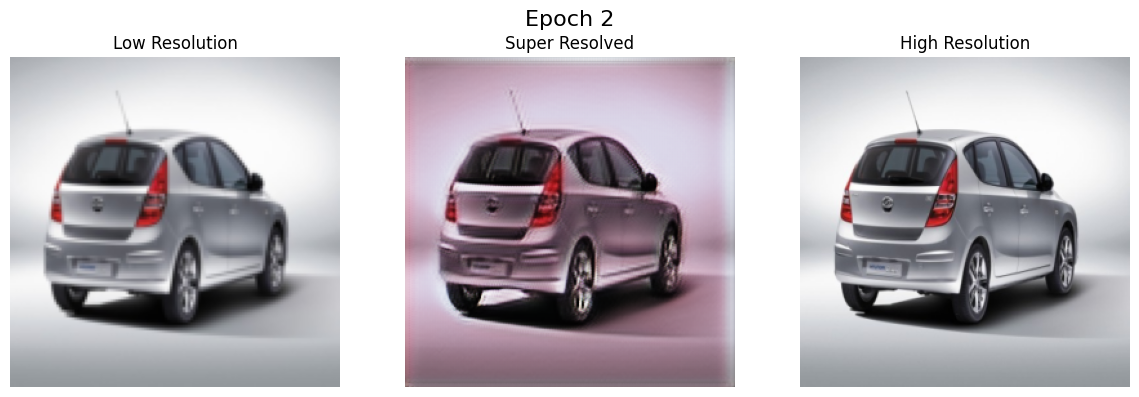

  0%|          | 0/4217 [00:00<?, ?it/s]

Epoch [3/5]
  Generator Loss:     0.00506197102367878
  Discriminator Loss: 0.5876532793045044
  Validation Loss:    0.011679845862090588


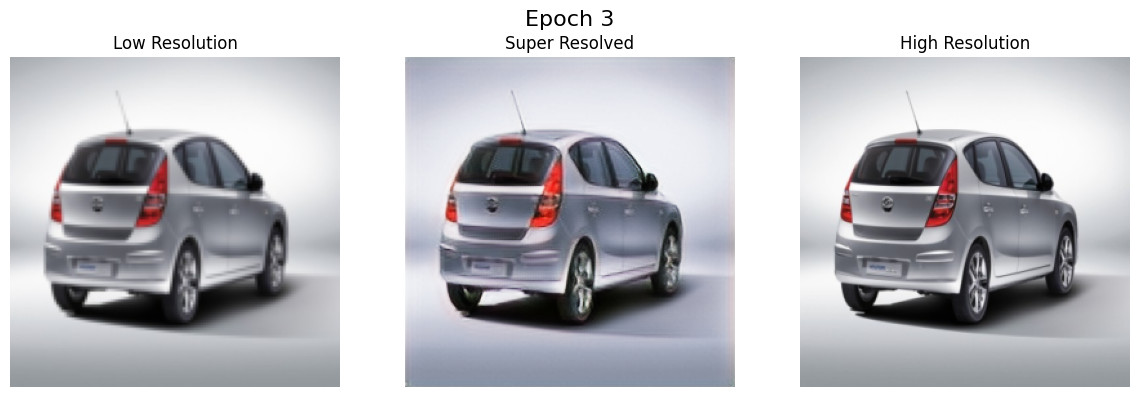

  0%|          | 0/4217 [00:00<?, ?it/s]

Epoch [4/5]
  Generator Loss:     0.0057688020169734955
  Discriminator Loss: 0.7359729409217834
  Validation Loss:    0.010227230144664645


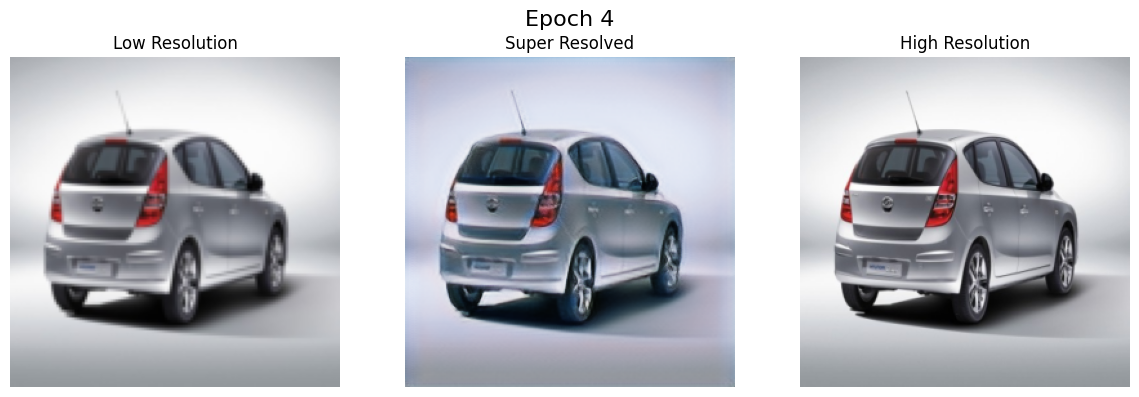

  0%|          | 0/4217 [00:00<?, ?it/s]

Epoch [5/5]
  Generator Loss:     0.00489747803658247
  Discriminator Loss: 0.166182741522789
  Validation Loss:    0.011263220803812146


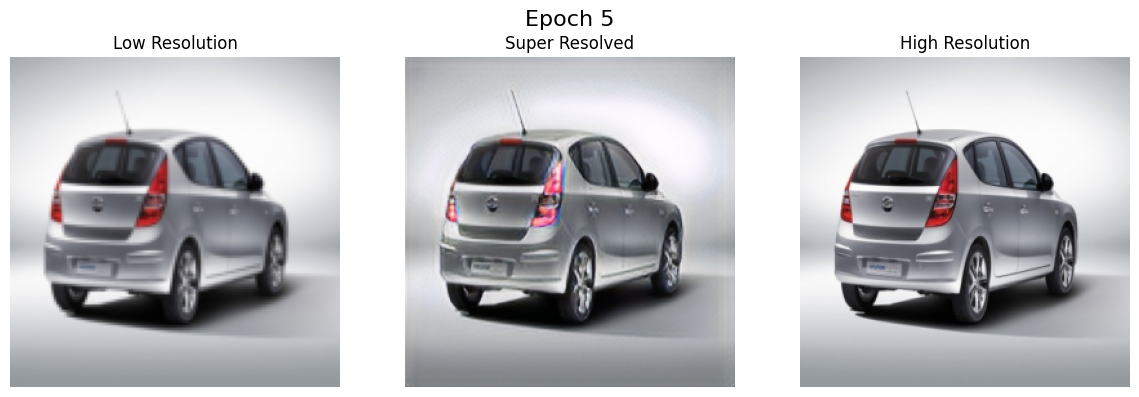

In [25]:
for epoch in range(num_epochs):
    loop = tqdm(train_loader)
    disc_loss = 0
    gen_loss = 0
    
    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        
        fake = gen(low_res)
        
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        
        disc_loss = disc_loss_fake + disc_loss_real
    
        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()
    
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss
    
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()
    v_loss = 0.0
    gen.eval()
    with torch.no_grad():
        for low_res, high_res in val_loader:
            high_res = high_res.to(device)
            low_res = low_res.to(device)
            fake = gen(low_res)
            content_loss = 0.006 * vgg_loss(fake, high_res)
            v_loss += (content_loss).item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Generator Loss:     {gen_loss.item()}")
    print(f"  Discriminator Loss: {disc_loss.item()}")
    print(f"  Validation Loss:    {v_loss}")
    gen_loss = gen_loss.detach().cpu()
    disc_loss = disc_loss.detach().cpu()
    d_losses.append(disc_loss)
    g_losses.append(gen_loss)
    v_losses.append(v_loss)
    visualize_sr_sample(gen,train_dataset,device,epoch+1)

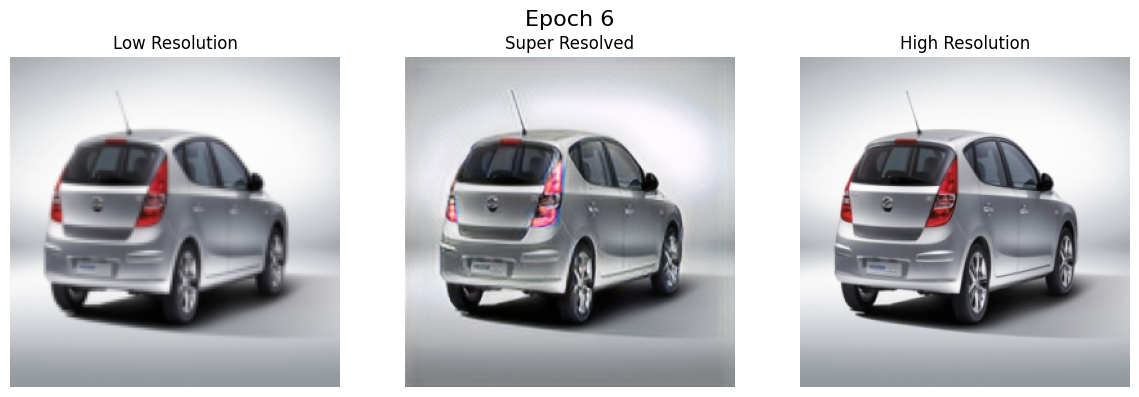

In [26]:
visualize_sr_sample(gen,train_dataset,device,num_epochs+1)

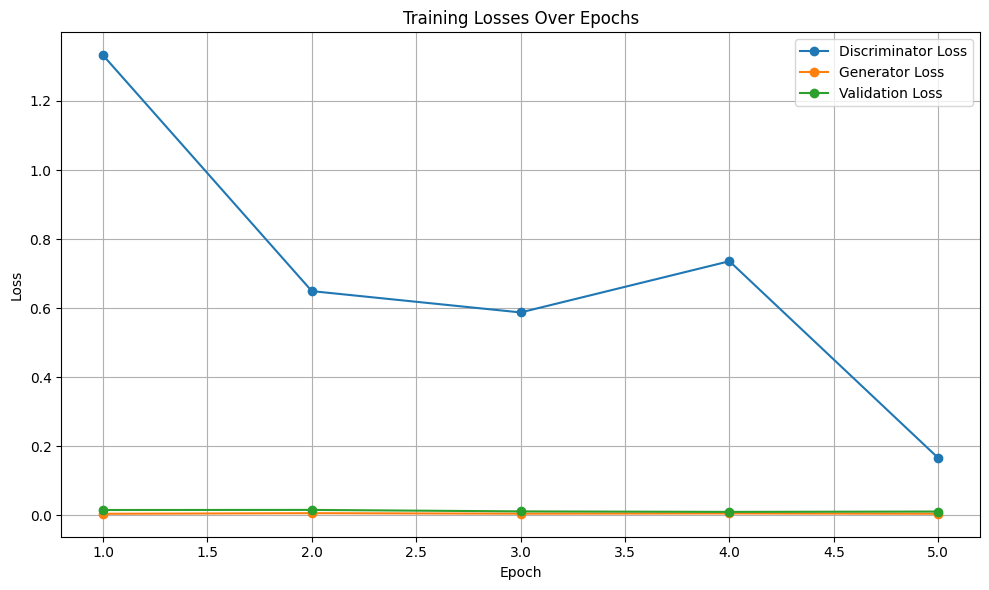

In [27]:
epochs = list(range(1, len(d_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, d_losses, label='Discriminator Loss', marker='o')
plt.plot(epochs, g_losses, label='Generator Loss', marker='o')
plt.plot(epochs, v_losses, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
torch.save(gen.state_dict(), "gen")
torch.save(disc.state_dict(), "disc")

In [29]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image
import torch

In [30]:
def test_sr_model(gen, val_loader, device):
    gen.eval()
    with torch.no_grad():
        for low_res, high_res in val_loader:
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            fake = gen(low_res)

            # Only take the first sample in the batch
            lr_img = low_res[0].clamp(0.0, 1.0).cpu().permute(1, 2, 0).numpy()
            sr_img = fake[0].clamp(0.0, 1.0).cpu().permute(1, 2, 0).numpy()
            hr_img = high_res[0].clamp(0.0, 1.0).cpu().permute(1, 2, 0).numpy()

            # Resize LR for visualization (optional, depends on your setup)
            if lr_img.shape != hr_img.shape:
                from skimage.transform import resize
                lr_img_vis = resize(lr_img, hr_img.shape, anti_aliasing=True)
            else:
                lr_img_vis = lr_img

            # Compute metrics
            psnr_value = psnr(hr_img, sr_img, data_range=1.0)
            ssim_value = ssim(hr_img, sr_img, data_range=1.0, channel_axis=-1, win_size=5)

            # Plot all images
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(lr_img_vis)
            plt.title('Low-Res Input')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(sr_img)
            plt.title(f'Generated (SR)\nPSNR: {psnr_value:.2f} | SSIM: {ssim_value:.4f}')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(hr_img)
            plt.title('High-Res Ground Truth')
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            break  # Only first image


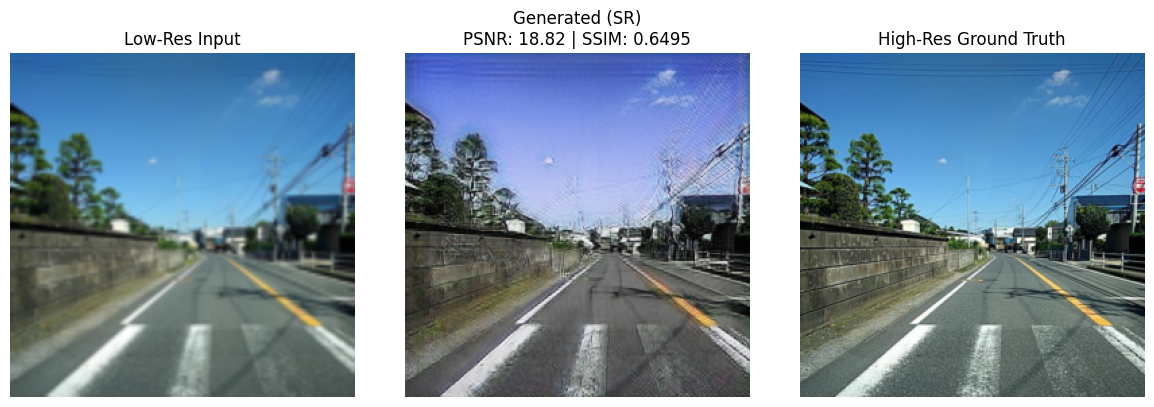

In [31]:
test_sr_model(gen,val_loader,device)